![lop](../../images/logo_diive1_128px.png)
# **Calculate VPD from air temperature and relative humidity**

**Notebook creation date**: 15 Jun 2023  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)
---
Example notebook for function `pkgs.createvar.vpd.calc_vpd_from_ta_rh` of the time series processing library `diive`.  

# Description

- Air temperature (TA) and relative humidity (RH) are two widely available measurements
- VPD can be calculated from TA and RH
- In this example, TA is gap-filled and then used in combination with RH (not gap-filled) to calculate VPD 
- For gap-filling TA, gap-filled SW_IN is required
- For gap-filling SW_IN, SW_IN_POT is used as an auxiliary variable
- `RandomForestTS` is used for gap-filling. It uses the input features in combination with timestamp info and lagged feature variants.

# Imports

In [1]:
from datetime import datetime
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from diive.core.io.files import loadfiles
from diive.core.times.times import insert_timestamp  # Used to insert TIMESTAMP_END
from diive.core.plotting.heatmap_datetime import HeatmapDateTime  # Used for plotting
from diive.pkgs.gapfilling.randomforest_ts import RandomForestTS  # Used for gap-filling
from diive.pkgs.createvar.vpd import calc_vpd_from_ta_rh  # Used to calculate VPD

C:\Users\holukas\AppData\Local\pypoetry\Cache\virtualenvs\diive-7H5NxUqg-py3.9\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


# Docstring

In [2]:
print(calc_vpd_from_ta_rh.__doc__)


    Calculate VPD from air temperature and relative humidity

    Args:
        df: Data
        rh_col: Name of column in *df* containing relative humidity data in %
        ta_col: Name of column in *df* containing air temperature data in °C

    Returns:
        VPD in kPa as Series

    Original code in ReddyProc:
        VPD.V.n <- 6.1078 * (1 - rH / 100) * exp(17.08085 * Tair / (234.175 + Tair))
        # See Kolle Logger Tools Software 2012 (Magnus coefficients for water between 0 and 100 degC)
        # Data vector of vapour pressure deficit (VPD, hPa (mbar))

    Reference:
        https://github.com/bgctw/REddyProc/blob/3c2b414c24900c17ab624c20b0e1726e6a813267/R/GeoFunctions.R#L96

    Checked against ReddyProc output, virtually the same, differences only 8 digits after comma.

    - Example notebook available in:
        notebooks/CalculateVariable/Calculate_VPD_from_TA_and_RH.ipynb

    


# Variables
- Names of the required variables in the datafiles

In [3]:
ta_col = 'TA_1_1_1'  # Air temperature is gap-filled and then used to calculate VPD
rh_col = 'RH_1_1_1'  # Relative humidity is used to calculate VPD
swin_col = 'SW_IN_1_1_1'  # Short-wave incoming radiation is used to gap-fill TA
swinpot_col = 'SW_IN_POT'  # Potential short-wave incoming radiation is used to gap-fill SW_IN

# Newly created variables

In [4]:
vpd_col = 'VPD_hPa'  # VPD will be newly calculated from gap-filled TA and non-gap-filled RH
vpd_gf_col = f'{vpd_col}_gfRF'  # Name of the gap-filled VPD in output
swin_gf_col = f'{swin_col}_gfRF'  # Name of the gap-filled SW_IN in output
ta_gf_col = f'{ta_col}_gfRF'  # Name of the gap-filled TA in output

# Source and output folders

In [5]:
SOURCEDIR = r"F:\Sync\luhk_work\80 - SITES\CH-FRU\DATA\Shared\2023-06-15 CH-FRU 2020-2022 TA RH VPD\0-sourcefiles"

# Load datafiles and collect in dataframe

In [6]:
data_df = loadfiles(filetype='FLUXNET-FULLSET-HH-CSV-30MIN',
                    sourcedir=SOURCEDIR,
                    limit_n_files=None,
                    fileext='.csv',
                    idstr='_fluxnet_')

Searching for EddyPro _fluxnet_ files in folder F:\Sync\luhk_work\80 - SITES\CH-FRU\DATA\Shared\2023-06-15 CH-FRU 2020-2022 TA RH VPD\0-sourcefiles ...
    Found 3 files:
       --> F:\Sync\luhk_work\80 - SITES\CH-FRU\DATA\Shared\2023-06-15 CH-FRU 2020-2022 TA RH VPD\0-sourcefiles\2020_eddypro_CH-FRU_FR-20230425-205325_fluxnet_2023-04-26T220030_adv.csv
       --> F:\Sync\luhk_work\80 - SITES\CH-FRU\DATA\Shared\2023-06-15 CH-FRU 2020-2022 TA RH VPD\0-sourcefiles\2021_eddypro_CH-FRU_FR-20230425-205131_fluxnet_2023-04-26T214014_adv.csv
       --> F:\Sync\luhk_work\80 - SITES\CH-FRU\DATA\Shared\2023-06-15 CH-FRU 2020-2022 TA RH VPD\0-sourcefiles\2022_eddypro_CH-FRU_FR-20230425-205042_fluxnet_2023-04-26T222351_adv.csv
Reading file 2020_eddypro_CH-FRU_FR-20230425-205325_fluxnet_2023-04-26T220030_adv.csv ...
Reading file 2021_eddypro_CH-FRU_FR-20230425-205131_fluxnet_2023-04-26T214014_adv.csv ...
Reading file 2022_eddypro_CH-FRU_FR-20230425-205042_fluxnet_2023-04-26T222351_adv.csv ...


In [7]:
data_df

,AIR_MV,AIR_DENSITY,AIR_RHO_CP,AIR_CP,AOA_METHOD,AXES_ROTATION_METHOD,BOWEN,BURBA_METHOD,BADM_LOCATION_LAT,BADM_LOCATION_LONG,BADM_LOCATION_ELEV,BADM_HEIGHTC,BADM_INST_SAMPLING_INT,BADM_INST_AVERAGING_INT,BADM_INST_MODEL_SA,...,W_T_SONIC_COV_IBROM_N0004,W_NUM_SPIKES,WD_FILTER_NREX,W_SPIKE_NREX,W_ABSLIM_NREX,W_VM97_TEST,W_LGD,W_KID,W_ZCD,W_ITC,W_ITC_TEST,WBOOST_APPLIED,WPL_APPLIED,ZL,ZL_UNCORR
TIMESTAMP_MIDDLE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-12-31 19:15:00,0.024907,1.16085,1169.83,1007.74,0.0,1.0,5.765210,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.003629,3.0,0.0,5.0,0.0,800000011.0,0.0,6.40148,630.0,6.0,1.0,0.0,1.0,3.079130,3.006370
2019-12-31 19:45:00,0.024865,1.16271,1171.77,1007.79,0.0,1.0,1.627180,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.002473,0.0,0.0,0.0,0.0,800000011.0,0.0,7.97684,255.0,47.0,3.0,0.0,1.0,-0.096300,-0.099549
2019-12-31 20:15:00,0.024910,1.16061,1169.68,1007.81,0.0,1.0,-5.226190,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.018346,6.0,0.0,9.0,0.0,800000111.0,0.0,8.32701,470.0,27.0,2.0,0.0,1.0,-0.780695,-0.771121
2019-12-31 20:45:00,0.024886,1.16183,1170.78,1007.70,0.0,1.0,2.296260,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.001395,5.0,0.0,9.0,0.0,800000011.0,0.0,8.49884,514.0,21.0,2.0,0.0,1.0,0.540130,0.545173
2019-12-31 21:15:00,0.024874,1.16239,1171.37,1007.73,0.0,1.0,-0.195424,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.005141,4.0,0.0,5.0,0.0,800000111.0,0.0,11.34600,266.0,9.0,1.0,0.0,1.0,-0.135396,-0.095764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31 22:45:00,0.025906,1.11442,1125.59,1010.02,0.0,1.0,-3.645490,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.000189,13.0,0.0,22.0,0.0,800001101.0,0.0,23.89100,424.0,9.0,1.0,0.0,1.0,0.316949,0.309181
2022-12-31 23:15:00,0.025770,1.12033,1131.50,1009.97,0.0,1.0,-1.667900,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,0.005310,4.0,0.0,7.0,0.0,800000011.0,0.0,10.83960,1305.0,60.0,4.0,0.0,1.0,-0.057874,-0.056127
2022-12-31 23:45:00,0.025757,1.12077,1132.08,1010.09,0.0,1.0,61.622800,0.0,47.1158,8.53778,982.0,0.4,20.0,30.0,NaN,...,-0.030341,4.0,0.0,6.0,0.0,800000111.0,0.0,10.21180,822.0,8.0,1.0,0.0,1.0,1.716370,1.677440


# Restrict years
- We want to use 2020, 2021 and 2022

In [8]:
locs = (data_df.index.year >= 2020) & (data_df.index.year <= 2022)
data_df = data_df[locs].copy()

# Subset of required variables

In [9]:
subset_df = data_df[[ta_col, rh_col, swinpot_col, swin_col]].copy()

# General settings for random forest gap-filling

In [10]:
rfsettings = dict(include_timestamp_as_features=True, lagged_variants=3, use_neighbor_years=True, feature_reduction=False, verbose=1)
rfsettings_model = dict(n_estimators=99, random_state=42, min_samples_split=2, min_samples_leaf=1, n_jobs=-1)

# Gap-filling SW_IN

In [11]:
rfts = RandomForestTS(df=subset_df, target_col=swin_col, **rfsettings)  # Initialize random forest gap-filling with settings
rfts.build_models(**rfsettings_model)  # Build random forest models
rfts.gapfill_yrs()  # Start gap-filling, using models
gapfilled_yrs_df, yrpool_gf_results = rfts.get_gapfilled_dataset()  # Get results
subset_df[swin_gf_col] = gapfilled_yrs_df[swin_gf_col].copy()  # Add gap-filled variable to subset

Created step-lagged variants for: ['TA_1_1_1', 'RH_1_1_1', 'SW_IN_POT']
No step-lagged variants for: ['SW_IN_1_1_1']
Added timestamp as columns: ['.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
Assigning years for gap-filling ...
Gap-filling for year 2020 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2021 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2022 is based on data from years [2020, 2021, 2022].

[BUILDING MODEL]    Based on data from years [2020, 2021, 2022] ==============================
[BUILDING MODEL]    Target column:  SW_IN_1_1_1  (50458 values)
[BUILDING MODEL]    Number of features used in model:  17
[BUILDING MODEL]    Names of features used in model:  ['TA_1_1_1', 'RH_1_1_1', 'SW_IN_POT', '.TA_1_1_1-1', '.TA_1_1_1-2', '.TA_1_1_1-3', '.RH_1_1_1-1', '.RH_1_1_1-2', '.RH_1_1_1-3', '.SW_IN_POT-1', '.SW_IN_POT-2', '.SW_IN_POT-3', '.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
[BUILDING MODEL]    Model data first timestamp:  2020-01-0

In [12]:
subset_df

,TA_1_1_1,RH_1_1_1,SW_IN_POT,SW_IN_1_1_1,SW_IN_1_1_1_gfRF
TIMESTAMP_MIDDLE,,,,,
2020-01-01 00:15:00,2.368980,63.0173,0.0,0.124416,0.124416
2020-01-01 00:45:00,1.221470,68.2483,0.0,0.226659,0.226659
2020-01-01 01:15:00,0.967274,69.5994,0.0,0.033943,0.033943
2020-01-01 01:45:00,1.118740,68.2259,0.0,0.198895,0.198895
2020-01-01 02:15:00,0.983717,69.7393,0.0,0.058019,0.058019
...,...,...,...,...,...
2022-12-31 21:45:00,10.350300,62.1516,0.0,0.000000,0.000000
2022-12-31 22:15:00,10.823600,60.4956,0.0,0.000000,0.000000
2022-12-31 22:45:00,10.400800,62.5504,0.0,0.000000,0.000000


# Gap-filling TA

In [13]:
gfcols = [ta_col, swin_gf_col]  # Target is TA, gap-filled SW_IN is feature
gf_df = subset_df[gfcols].copy()  # Collect variables for gap-filling in dataframe
rfts = RandomForestTS(df=gf_df, target_col=ta_col, **rfsettings)  # Initialize random forest gap-filling with settings
rfts.build_models(**rfsettings_model)  # Build random forest models
rfts.gapfill_yrs()  # Start gap-filling, using models
gapfilled_yrs_df, yrpool_gf_results = rfts.get_gapfilled_dataset()  # Get results
subset_df[ta_gf_col] = gapfilled_yrs_df[ta_gf_col].copy()  # Add gap-filled variable to subset

Created step-lagged variants for: ['SW_IN_1_1_1_gfRF']
No step-lagged variants for: ['TA_1_1_1']
Added timestamp as columns: ['.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
Assigning years for gap-filling ...
Gap-filling for year 2020 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2021 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2022 is based on data from years [2020, 2021, 2022].

[BUILDING MODEL]    Based on data from years [2020, 2021, 2022] ==============================
[BUILDING MODEL]    Target column:  TA_1_1_1  (50607 values)
[BUILDING MODEL]    Number of features used in model:  9
[BUILDING MODEL]    Names of features used in model:  ['SW_IN_1_1_1_gfRF', '.SW_IN_1_1_1_gfRF-1', '.SW_IN_1_1_1_gfRF-2', '.SW_IN_1_1_1_gfRF-3', '.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
[BUILDING MODEL]    Model data first timestamp:  2020-01-01T01:45:00.000000000
[BUILDING MODEL]    Model data last timestamp:  2022-12-31T23:45:00.000000000
[BUILDING M

In [14]:
subset_df

,TA_1_1_1,RH_1_1_1,SW_IN_POT,SW_IN_1_1_1,SW_IN_1_1_1_gfRF,TA_1_1_1_gfRF
TIMESTAMP_MIDDLE,,,,,,
2020-01-01 00:15:00,2.368980,63.0173,0.0,0.124416,0.124416,2.368980
2020-01-01 00:45:00,1.221470,68.2483,0.0,0.226659,0.226659,1.221470
2020-01-01 01:15:00,0.967274,69.5994,0.0,0.033943,0.033943,0.967274
2020-01-01 01:45:00,1.118740,68.2259,0.0,0.198895,0.198895,1.118740
2020-01-01 02:15:00,0.983717,69.7393,0.0,0.058019,0.058019,0.983717
...,...,...,...,...,...,...
2022-12-31 21:45:00,10.350300,62.1516,0.0,0.000000,0.000000,10.350300
2022-12-31 22:15:00,10.823600,60.4956,0.0,0.000000,0.000000,10.823600
2022-12-31 22:45:00,10.400800,62.5504,0.0,0.000000,0.000000,10.400800


# Calculation of VPD

In [15]:
subset_df[vpd_col] = calc_vpd_from_ta_rh(df=subset_df, ta_col=ta_gf_col, rh_col=rh_col)

In [16]:
subset_df

,TA_1_1_1,RH_1_1_1,SW_IN_POT,SW_IN_1_1_1,SW_IN_1_1_1_gfRF,TA_1_1_1_gfRF,VPD_hPa
TIMESTAMP_MIDDLE,,,,,,,
2020-01-01 00:15:00,2.368980,63.0173,0.0,0.124416,0.124416,2.368980,0.268025
2020-01-01 00:45:00,1.221470,68.2483,0.0,0.226659,0.226659,1.221470,0.211907
2020-01-01 01:15:00,0.967274,69.5994,0.0,0.033943,0.033943,0.967274,0.199197
2020-01-01 01:45:00,1.118740,68.2259,0.0,0.198895,0.198895,1.118740,0.210489
2020-01-01 02:15:00,0.983717,69.7393,0.0,0.058019,0.058019,0.983717,0.198516
...,...,...,...,...,...,...,...
2022-12-31 21:45:00,10.350300,62.1516,0.0,0.000000,0.000000,10.350300,0.476351
2022-12-31 22:15:00,10.823600,60.4956,0.0,0.000000,0.000000,10.823600,0.513156
2022-12-31 22:45:00,10.400800,62.5504,0.0,0.000000,0.000000,10.400800,0.472927


# Gap-filling VPD

In [17]:
gfcols = [vpd_col, swin_gf_col, ta_gf_col]
gf_df = subset_df[gfcols].copy()
rfts = RandomForestTS(df=gf_df, target_col=vpd_col, **rfsettings)
rfts.build_models(**rfsettings_model)
rfts.gapfill_yrs()
gapfilled_yrs_df, yrpool_gf_results = rfts.get_gapfilled_dataset()
subset_df[vpd_gf_col] = gapfilled_yrs_df[vpd_gf_col].copy()

Created step-lagged variants for: ['SW_IN_1_1_1_gfRF', 'TA_1_1_1_gfRF']
No step-lagged variants for: ['VPD_hPa']
Added timestamp as columns: ['.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
Assigning years for gap-filling ...
Gap-filling for year 2020 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2021 is based on data from years [2020, 2021, 2022].
Gap-filling for year 2022 is based on data from years [2020, 2021, 2022].

[BUILDING MODEL]    Based on data from years [2020, 2021, 2022] ==============================
[BUILDING MODEL]    Target column:  VPD_hPa  (50607 values)
[BUILDING MODEL]    Number of features used in model:  13
[BUILDING MODEL]    Names of features used in model:  ['SW_IN_1_1_1_gfRF', 'TA_1_1_1_gfRF', '.SW_IN_1_1_1_gfRF-1', '.SW_IN_1_1_1_gfRF-2', '.SW_IN_1_1_1_gfRF-3', '.TA_1_1_1_gfRF-1', '.TA_1_1_1_gfRF-2', '.TA_1_1_1_gfRF-3', '.YEAR', '.DOY', '.WEEK', '.MONTH', '.HOUR']
[BUILDING MODEL]    Model data first timestamp:  2020-01-01T01:45:00.000000

In [18]:
subset_df

,TA_1_1_1,RH_1_1_1,SW_IN_POT,SW_IN_1_1_1,SW_IN_1_1_1_gfRF,TA_1_1_1_gfRF,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,,,,,
2020-01-01 00:15:00,2.368980,63.0173,0.0,0.124416,0.124416,2.368980,0.268025,0.268025
2020-01-01 00:45:00,1.221470,68.2483,0.0,0.226659,0.226659,1.221470,0.211907,0.211907
2020-01-01 01:15:00,0.967274,69.5994,0.0,0.033943,0.033943,0.967274,0.199197,0.199197
2020-01-01 01:45:00,1.118740,68.2259,0.0,0.198895,0.198895,1.118740,0.210489,0.210489
2020-01-01 02:15:00,0.983717,69.7393,0.0,0.058019,0.058019,0.983717,0.198516,0.198516
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,10.350300,62.1516,0.0,0.000000,0.000000,10.350300,0.476351,0.476351
2022-12-31 22:15:00,10.823600,60.4956,0.0,0.000000,0.000000,10.823600,0.513156,0.513156
2022-12-31 22:45:00,10.400800,62.5504,0.0,0.000000,0.000000,10.400800,0.472927,0.472927


# Plot some variables

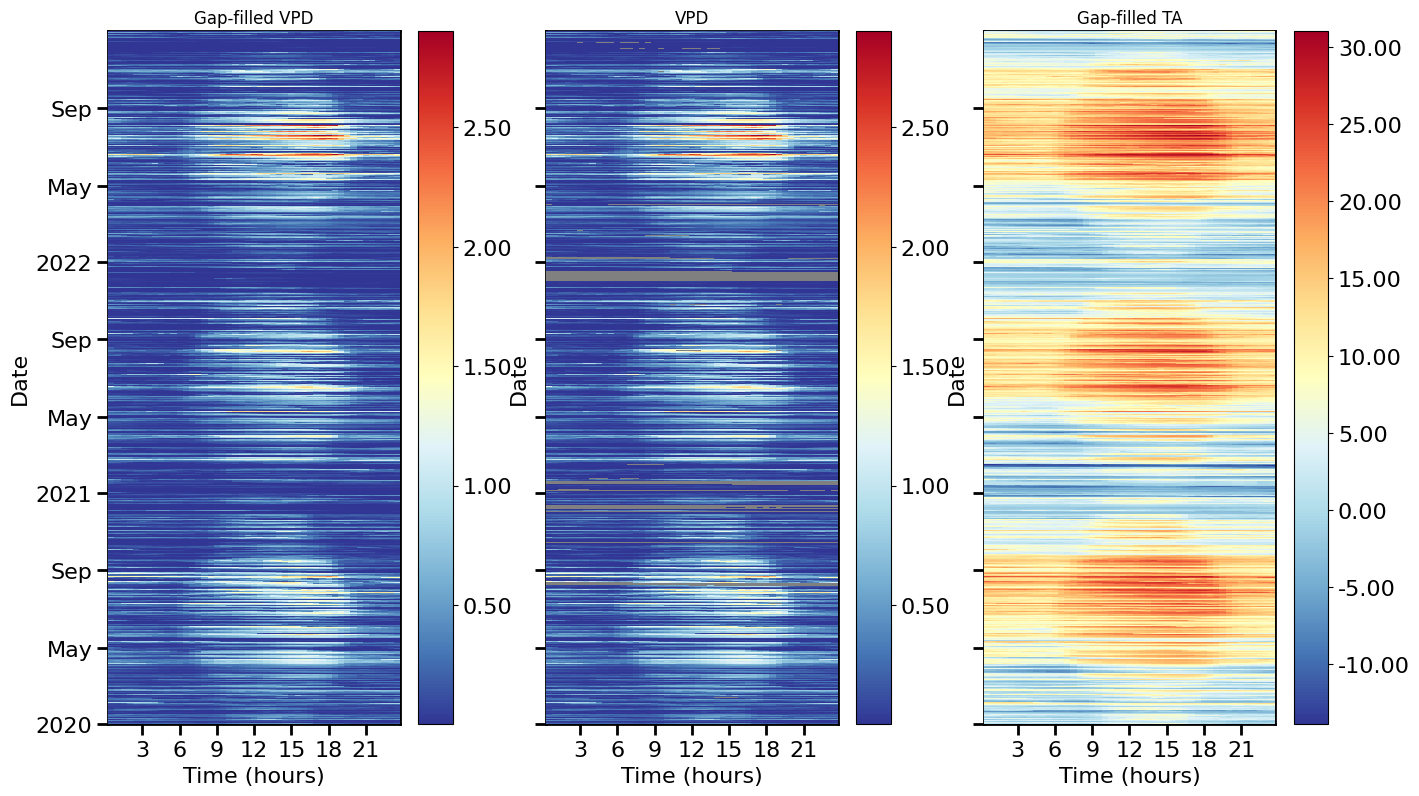

In [19]:
fig = plt.figure(facecolor='white', figsize=(16, 9))
gs = gridspec.GridSpec(1, 3)  # rows, cols
ax_fc = fig.add_subplot(gs[0, 0])
ax_le = fig.add_subplot(gs[0, 1])
ax_ta = fig.add_subplot(gs[0, 2])
HeatmapDateTime(ax=ax_fc, series=subset_df['VPD_hPa_gfRF']).plot()
HeatmapDateTime(ax=ax_le, series=subset_df['VPD_hPa']).plot()
HeatmapDateTime(ax=ax_ta, series=subset_df['TA_1_1_1_gfRF']).plot()
ax_fc.set_title("Gap-filled VPD", color='black')
ax_le.set_title("VPD", color='black')
ax_ta.set_title("Gap-filled TA", color='black')
ax_le.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)
ax_ta.tick_params(left=True, right=False, top=False, bottom=True,
                     labelleft=False, labelright=False, labeltop=False, labelbottom=True)

# Insert TIMESTAMP_END
- `diive` uses TIMESTAMP_MIDDLE for calculations, but sometimes TIMESTAMP_END is required for output files

In [20]:
subset_df = insert_timestamp(data=subset_df, convention='end')
subset_df

,TIMESTAMP_END,TA_1_1_1,RH_1_1_1,SW_IN_POT,SW_IN_1_1_1,SW_IN_1_1_1_gfRF,TA_1_1_1_gfRF,VPD_hPa,VPD_hPa_gfRF
TIMESTAMP_MIDDLE,,,,,,,,,
2020-01-01 00:15:00,2020-01-01 00:30:00,2.368980,63.0173,0.0,0.124416,0.124416,2.368980,0.268025,0.268025
2020-01-01 00:45:00,2020-01-01 01:00:00,1.221470,68.2483,0.0,0.226659,0.226659,1.221470,0.211907,0.211907
2020-01-01 01:15:00,2020-01-01 01:30:00,0.967274,69.5994,0.0,0.033943,0.033943,0.967274,0.199197,0.199197
2020-01-01 01:45:00,2020-01-01 02:00:00,1.118740,68.2259,0.0,0.198895,0.198895,1.118740,0.210489,0.210489
2020-01-01 02:15:00,2020-01-01 02:30:00,0.983717,69.7393,0.0,0.058019,0.058019,0.983717,0.198516,0.198516
...,...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,2022-12-31 22:00:00,10.350300,62.1516,0.0,0.000000,0.000000,10.350300,0.476351,0.476351
2022-12-31 22:15:00,2022-12-31 22:30:00,10.823600,60.4956,0.0,0.000000,0.000000,10.823600,0.513156,0.513156
2022-12-31 22:45:00,2022-12-31 23:00:00,10.400800,62.5504,0.0,0.000000,0.000000,10.400800,0.472927,0.472927


# Resample to daily averages

In [21]:
subset_df = subset_df[[vpd_gf_col, rh_col, ta_gf_col, swin_gf_col]].copy()
subset_df = subset_df.resample('D').mean()
subset_df

,VPD_hPa_gfRF,RH_1_1_1,TA_1_1_1_gfRF,SW_IN_1_1_1_gfRF
TIMESTAMP_MIDDLE,,,,
2020-01-01,0.232408,66.909267,1.682248,81.352147
2020-01-02,0.273399,63.023042,1.845635,78.957017
2020-01-03,0.234364,71.299173,3.461662,51.742695
2020-01-04,0.031342,95.812173,1.962559,11.821965
2020-01-05,0.038742,93.733250,-1.175804,76.297763
...,...,...,...,...
2022-12-27,0.023258,96.818958,2.224557,37.944000
2022-12-28,0.287455,67.473777,3.919859,71.006788
2022-12-29,0.310548,66.922654,5.652173,35.264744


# Plot daily means

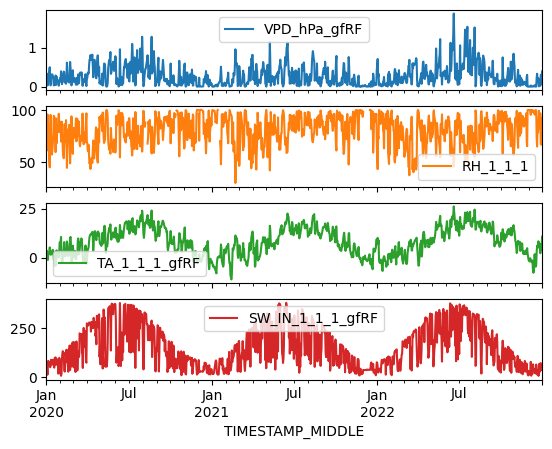

In [22]:
subset_df.plot(subplots=True)
plt.show()

# Save to file

In [23]:
subset_df.index.name = "TIMESTAMP"
outfile = "CH-FRU_VPD_RH_TA_2020-2022_20230615.csv"
subset_df.to_csv(outfile)

# Finish

In [24]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2023-06-15 20:13:50
